In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from saif.crs_model.peakdetector import pk_indxs
import pandas as pd



### Load Data

In [2]:
seismic = pd.read_csv("/Users/pmh/Desktop/temporal_datasets_decatur_illinois_seismic.csv",index_col=None)
pressure = pd.read_csv("/Users/pmh/Desktop/temporal_datasets_decatur_illinois_pressure.csv",index_col=None)

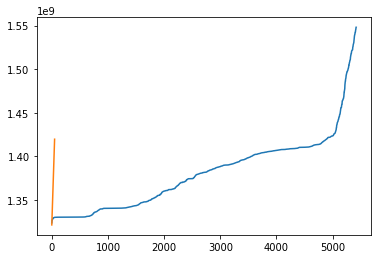

In [3]:
plt.plot(seismic['epoch'])
plt.plot(pressure['epoch'])

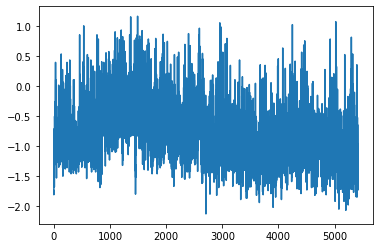

In [4]:
plt.plot(seismic['magnitude'])

### Process $N(t)$

- Pressure data and seismic events are recorded at different times.
    - First goal: Clip all data to the time interval where we have samples for both pressure and seismic activity
    - Second goal: linearly interpolate the seismic data so that the event times align with the pressure data.
    - Third goal: empirically compute the rate (numerical derivative), in order to define R0.
- Partition the data into **main shock** and **interseismic** regions.
    - This should be done by a peak detector, but right now it is done manually (by visual inspection).

In [4]:
from scipy.interpolate import interp1d

Obtain the time intervals for the seismic data, and creating the interpolator.

In [5]:
magnitude=pd.DataFrame(seismic['magnitude']).to_numpy().squeeze()
event_times = pd.DataFrame(seismic['epoch']).to_numpy().squeeze()
start_t = event_times[0]
end_t = event_times[-1]
event_times = event_times/86400

t_n = (event_times - event_times[0])
t_n=t_n.squeeze()
n_cnts = np.arange(len(t_n))

n_func1 = interp1d(t_n, n_cnts, kind='linear')

Obtain the time intervals for the pressure data, and interpolate the seismic data

In [6]:
t_p = pd.DataFrame(pressure['epoch']).to_numpy().squeeze()
start_idx = np.where(t_p > start_t)[0][0]
end_idx = len(t_p)

end_t=np.where(event_times*86400 > t_p[end_idx-1])[0][0]

t_p=(t_p[start_idx+1:end_idx]-t_p[start_idx+1])/86400
p = pd.DataFrame(pressure['pressure']).to_numpy()[start_idx+1:end_idx].squeeze()
dpdt = pd.DataFrame(pressure['dpdt']).to_numpy()[start_idx+1:end_idx].squeeze()

t_new = np.arange(0,t_p[-1])

delta_t = (t_new[1:] - t_new[:-1])*86400

n_func2 = interp1d(t_p, p, kind='linear')
n_func3 = interp1d(t_p, dpdt, kind='linear')

n_interpolated = n_func1(t_new) # interpolated number of earthquakes 
p_interpolated = n_func2(t_new) # interpolated number of earthquakes 
dpdt_interpolated = n_func3(t_new) # interpolated number of earthquakes 

p_interpolated = torch.FloatTensor(p_interpolated)
dpdt_interpolated = torch.FloatTensor(dpdt_interpolated)
delta_t = torch.FloatTensor(delta_t)
empirical_rate = np.gradient(n_interpolated, t_new)

[-1.74 -1.81 -1.17 ... -1.41 -1.73 -1.2 ]
[   0   67   76   77  142  193  194  205  210  227  256  385  568  641
  739  743  984 1068]


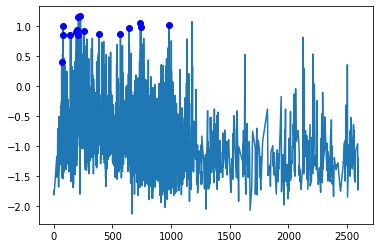

In [7]:
plt.plot(event_times-event_times[0], magnitude)
print(magnitude)
peak_indexs=pk_indxs(magnitude[0:end_t],trshd=0.9, min_dist=10)

firstquake=np.where(magnitude > 0.2)[0][0]
peak_indexs=np.insert(peak_indexs,0,firstquake)
   
plt.plot(event_times[peak_indexs]-event_times[0],magnitude[peak_indexs],'o',color='b')

peak_indexs=(np.array((event_times[peak_indexs]-event_times[0])/t_new[-1]*len(t_new),dtype=int))

peak_indexs=np.insert(peak_indexs,0,0)
peak_indexs=np.insert(peak_indexs,np.size(peak_indexs),np.size(t_new)-1)
print(peak_indexs)


[  0  76 193 278 441 586 767 888]


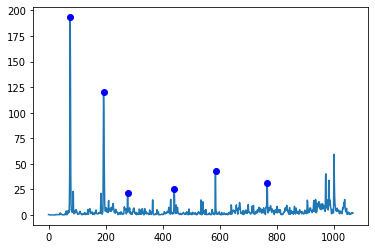

In [8]:
peak_indexs=pk_indxs(empirical_rate[0:888],trshd=0.1, min_dist=10)
plt.plot(empirical_rate)
plt.plot(peak_indexs,empirical_rate[peak_indexs],'o',color='b')
peak_indexs=np.insert(peak_indexs,0,0)
peak_indexs=np.insert(peak_indexs,np.size(peak_indexs),888)
print(peak_indexs)


In [22]:
#empirical_rate = np.gradient(n_interpolated, t_p_interpolated)
#peak_indexs=pk_indxs(empirical_rate,trshd=0.08, min_dist=50)
#plt.plot(t_p_interpolated, empirical_rate)
#plt.plot(t_p_interpolated[peak_indexs],empirical_rate[peak_indexs],'o',color='b')
#peak_indexs=np.insert(peak_indexs,0,0)
#peak_indexs=np.insert(peak_indexs,np.size(peak_indexs),np.size(t_p_interpolated)-1)
#print(peak_indexs)
#print(np.size(peak_indexs))

1069


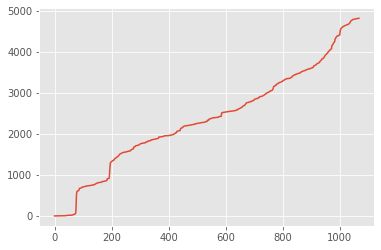

In [23]:
plt.plot(t_new, n_interpolated)
print(len(n_interpolated))

Examining the first interseismic chunk (from t=0 years to t=1.3 years)

### Define site constants

### Sampling the grid

We keep the rate factor fixed, and examine the landscape for mu_minus_alpha and rate_coeff.

In [25]:
params = torch.FloatTensor([[0.5,1e-2,1e-4]])


# mu_minus_alpha_mesh = torch.linspace(0.1,1.0,101)
# rate_coeff_mesh = 10 ** torch.linspace(-4,-1,101)
# grid_mu, grid_rate = torch.meshgrid(mu_minus_alpha_mesh, rate_coeff_mesh, indexing='ij')

# params = torch.stack([
#     grid_mu.flatten(),
#     grid_rate.flatten(),
#     163.7424 / 1e6 * torch.ones_like(grid_rate.flatten()), # rate_factor 
# ]).T

# params.requires_grad_()



### Run Model

Define the criterion: MSELoss.

- Be careful: we may need to normalize the data before using MSELoss.
- In future, we might forecast rate (or, $\Delta N(t)$) since this is easier to bound than total number.

In [9]:
mpa_yr2pa_s = 1e6 / 365.25 / 86400
site_info = {
    'tectonic_shear_stressing_rate' : 3.5e-4 * mpa_yr2pa_s, # Pa / s
    'tectonic_normal_stressing_rate' : 0, # Pa/s
    'sigma' : 30 * 1e6, # Pa
    'biot' : 0.3, # dimensionless
    #'background_rate' : 1.36 / 365.25 / 86400, # event/second,
    'background_rate' : empirical_rate[0] / 365.25 / 86400, # event/second,
    'init_delta_t' : delta_t[0].item(), 
    'mu_minus_alpha_up_limit' : 0.5,
    'rate_coeff_up_limit' : 0.1,
    'rate_factor_up_limit' : 0.002}

In [59]:
from model import CRSModel
import torch.optim as optim
import torch.nn.functional as F
model = CRSModel(site_info)

params = torch.FloatTensor([[1,0.01,0.01]])

params.requires_grad=True
params.register_hook(lambda g: F.normalize(g))

optimizer = optim.SGD(params=[params],lr=1,momentum=0.1)

criterion = nn.HuberLoss(reduction='mean')
R0, N0 , n_target0 = torch.ones(1, 1),torch.ones(1, 1),torch.FloatTensor([])

save_loss=[]

In [60]:
train_loss = []
eval_loss = []

# for i in range(start:0.8* length):
#     train_code
    
# for i in range(0.8*length :end):
#     compute_loss

optimizer = optim.SGD(params=[params],lr=0.01,momentum=0.1)
for epoch in range(500):
    R0, N0 , n_target0 = torch.ones(1, 1),torch.ones(1, 1),torch.FloatTensor([])
    for i in range(np.size(peak_indexs)-1):
             mpa_yr2pa_s = 1e6 / 365.25 / 86400
             site_info = {
                          'tectonic_shear_stressing_rate' : 3.5e-4 * mpa_yr2pa_s, # Pa / s
                          'tectonic_normal_stressing_rate' : 0, # Pa/s
                          'sigma' : 30 * 1e6, # Pa
                          'biot' : 0.3, # dimensionless
                          #'background_rate' : 1.36 / 365.25 / 86400, # event/second,
                          'background_rate' : empirical_rate[peak_indexs[i]]/ 86400, # event/second,
                          'init_delta_t' : delta_t[0].item(),    
                          'mu_minus_alpha_up_limit':0.5,
                          'rate_coeff_up_limit': 0.1,
                          'rate_factor_up_limit': 0.002}
             model = CRSModel(site_info)
             p0 = torch.FloatTensor(p_interpolated)[peak_indexs[i]+1:peak_indexs[i+1]]
             dpdt0 = torch.FloatTensor(dpdt_interpolated)[peak_indexs[i]+1:peak_indexs[i+1]]
             delta_t0 = torch.FloatTensor(delta_t)[peak_indexs[i]+1:peak_indexs[i+1]]
             Rt, Nt = model(params, p0, dpdt0, delta_t0)
             R0=torch.cat((R0,Rt),dim=-1)
             #print(N0.detach()[0][-1])
             Nt=torch.add(Nt,N0.detach()[0][-1])
             #print(N0.detach())
             N0=torch.cat((N0,Nt),dim=-1)
             n_target= torch.FloatTensor(n_interpolated)[peak_indexs[i]:peak_indexs[i+1]]
             n_target0=torch.cat((n_target0,n_target),dim=-1)
             #print(n_target0.detach().size(),(N0[:,1:]).squeeze().detach().size())

    # loss = criterion(Nt[:,1:], n_target[None,:]) # Need to define a loss function that compares with the real data
    # Define a MSE of forecasted number Nt with the ground truth
    
    loss1 = criterion((N0[:,1:]).squeeze(), n_target0) 
    print('loss is ' + str(loss1.item()))
    train_loss.append(loss1.item())
    optimizer.zero_grad()
    loss1.backward()
    optimizer.step()
    Nt.shape
    #######
    p_eval = torch.FloatTensor(p_interpolated)[888:1068]
    dpdt_eval = torch.FloatTensor(dpdt_interpolated)[888:1068]
    delta_eval = torch.FloatTensor(delta_t)[888:1068]
    n_target_eval= torch.FloatTensor(n_interpolated)[888:1068]
    
    R_eval, N_eval = model(params.data, p_eval, dpdt_eval, delta_eval)
    loss2 = criterion((N_eval[:,1:]).squeeze()+N0.detach()[0][-1], n_target_eval)
    eval_loss.append(loss2.item())

loss is 6720.642578125
loss is 6687.02490234375
loss is 6650.271484375
loss is 6613.375
loss is 6576.111328125
loss is 6538.80224609375
loss is 6501.45263671875
loss is 6464.41455078125
loss is 6427.13671875
loss is 6390.6611328125
loss is 6353.05078125
loss is 6316.44873046875
loss is 6278.927734375
loss is 6241.41162109375
loss is 6203.8056640625
loss is 6170.25
loss is 6132.8984375
loss is 6095.3388671875
loss is 6058.33447265625
loss is 6020.7265625
loss is 5982.97412109375
loss is 5945.72705078125
loss is 5908.46826171875
loss is 5870.94189453125
loss is 5833.8125
loss is 5796.234375
loss is 5758.73974609375
loss is 5720.859375
loss is 5683.4287109375
loss is 5645.7216796875
loss is 5608.271484375
loss is 5570.6884765625
loss is 5533.162109375
loss is 5495.6435546875
loss is 5458.52197265625
loss is 5421.0322265625
loss is 5383.9169921875
loss is 5346.41455078125
loss is 5308.77685546875
loss is 5271.26220703125
loss is 5233.77587890625
loss is 5196.900390625
loss is 5159.37744140

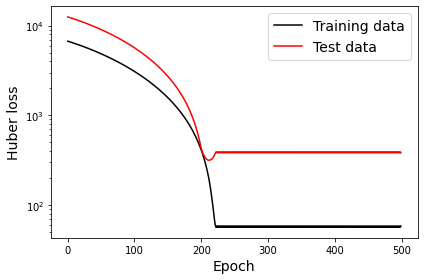

In [61]:
fig = plt.figure()
#n_epoch = np.arange(300) + 1
plt.plot( train_loss, '-k',  label='Training data')
plt.plot( eval_loss, '-r',  label='Test data')
plt.gca().set_yscale('log')
plt.legend(loc='best', prop={'size':14})
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Huber loss', fontsize=14)
plt.tight_layout()
plt.show()

In [62]:
p0 = torch.FloatTensor(p_interpolated)[peak_indexs[i+1]+1:]
dpdt0 = torch.FloatTensor(dpdt_interpolated)[peak_indexs[i+1]+1:]
delta_t0 = torch.FloatTensor(delta_t)[peak_indexs[i+1]:]
Rt_pre, Nt_pre = model(params, p0, dpdt0, delta_t0)

tensor(0.3646) tensor(0.0152) tensor(0.0003)


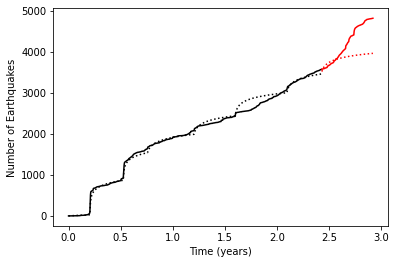

In [64]:
plt.plot(t_new[0:888]/365.25,(N0[:,1:]).squeeze().detach().numpy(),':k')
plt.plot(t_new[889:]/365.25,(Nt_pre[:,1:]+N0.detach()[0][-1]).squeeze().detach().numpy(),':r')
plt.plot(t_new[0:888]/365.25,n_interpolated[0:888],'-k')
plt.plot(t_new[889:]/365.25,n_interpolated[889:],'-r')
plt.xlabel("Time (years)")
plt.ylabel("Number of Earthquakes")
print((torch.sigmoid(params.data[0][0])*0.5),(torch.sigmoid(params.data[0][1])*0.1),(torch.sigmoid(params.data[0][2])*0.002))

In [32]:
import csv
 
# data to be written row-wise in csv file
data = pd.DataFrame([save_loss,save_lossn])
data.to_csv("crs_loss.csv")
 